# Bank Marketing UCI Modeling

### Necessary imports

In [1]:
pip install git+https://github.com/modelplot/modelplotpy.git

  Cloning https://github.com/modelplot/modelplotpy.git to /tmp/pip-req-build-r9cxnenv
  Running command git clone --filter=blob:none --quiet https://github.com/modelplot/modelplotpy.git /tmp/pip-req-build-r9cxnenv
  Resolved https://github.com/modelplot/modelplotpy.git to commit 83ca84e67c357ee3bd98e296b94219c1a0863f68
  Preparing metadata (setup.py) ... done
  Created wheel for modelplotpy: filename=modelplotpy-1.0.0-py2.py3-none-any.whl size=36250 sha256=11632b1c5d83007f99d840155461e4f60fd8c3b81658494c5f760175e9baa1d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-70bhrf4y/wheels/bd/c9/e9/9fd5236a7377d81a5689c597f279013d333551519fdfdf85d4
Successfully built modelplotpy
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import logging
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
import optuna
import shap
import modelplotpy as mp
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, AllKNN
from imblearn.combine import SMOTEENN, SMOTETomek

### Reading data

* This data already contains 'ts_month' feature, duplicates are dropped, some bool features have been encoded. These manipulations were conducted in EDA part.

In [3]:
def read_data(path: str, files: list, separator=','):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file, sep=separator))
    return dataframes


path = '/kaggle/input/bank-marketing-uci/'
files = ['bank_data.csv']
bank_data = read_data(path, files)[0]
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Data distribution by target feature. As we can see, '0' class outweigh '1' class, so the data can be considered as imbalanced.

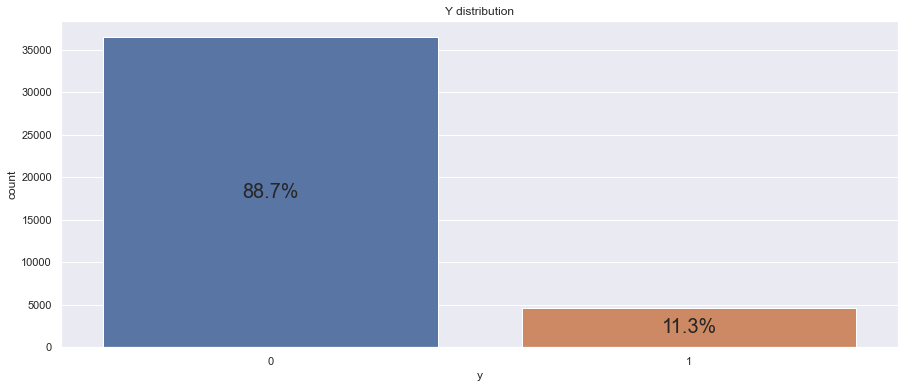

* The green line represents total number of calls conducted in each month
* The blue line shows number of positive outcomes ('y' == 1)
* As we can see, most calls were performed during first 9 month of campaign, whereas in the next months number of calls decreased drasticaly.

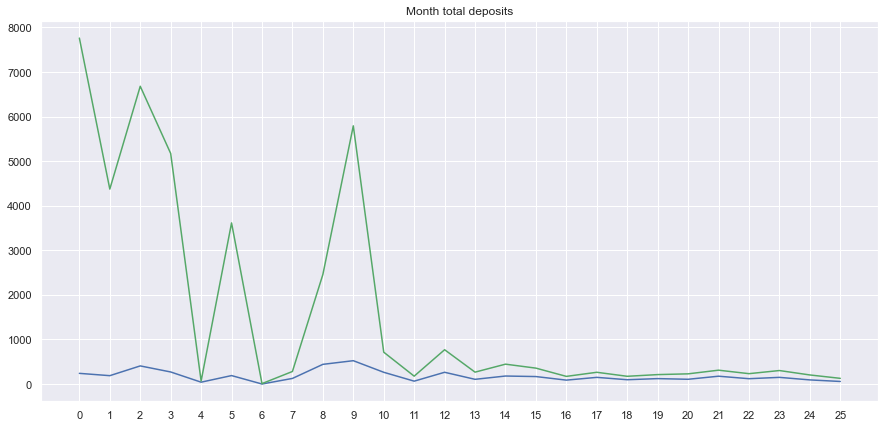

* The line determines the rate of positive outcomes over the time.

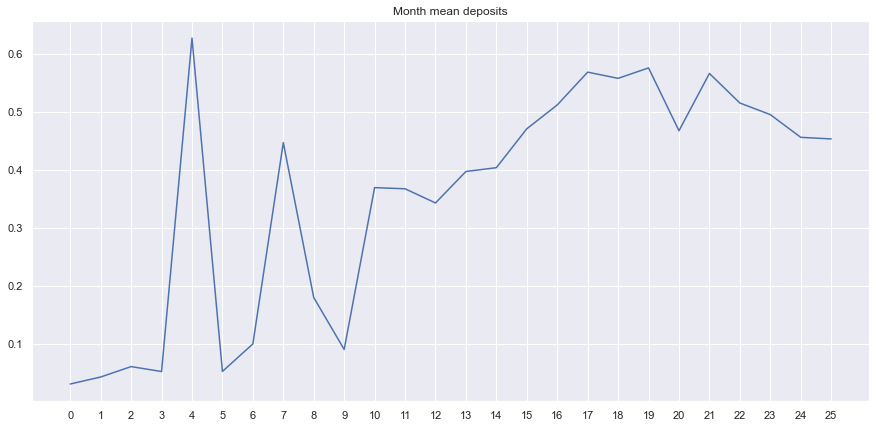

* From these two plots we can understand, that if we'll split data for train/valid/test according to TimeSeries rules, the resulted distributions of target variable in train and valid/test sets will be different, what makes model building and evaluation controversial. Thus something needs to be done, to make this process possible and adequate.

## Approach 1: Balancing Data
### Intuition:
So as to make train and validation/test data alike I'll use data balancing techniques such as Random Over/Under Sampling and SMOTE/ENN/Tomek.

### Feature Engineering

* Dropping 'duration' feature to avoid leaks

In [4]:
bank_data.drop(columns='duration', inplace=True)

* Using binning for 'age' feature

In [5]:
def make_bins(data, feature, label_names, cut_points):
    data[feature] = pd.cut(data[feature], cut_points, labels=label_names)

    
age_labels = [1, 2, 3, 4]
age_cut_pts = [16, 30, 45, 60, 98]
make_bins(bank_data, 'age', age_labels, age_cut_pts)
bank_data['age'] = bank_data['age'].astype('int8')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,3,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Encoding categorial features

* Encoding consecutive features ('month' and 'day_of_week')

In [6]:
def encode_consecutive(data, feature, encoding):
    data[feature] = data[feature].map(encoding)
    

encode_consecutive(bank_data, 'day_of_week', {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})
encode_consecutive(bank_data, 'month', {'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,
                                        'mar': 3, 'apr': 4})
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,3,housemaid,married,basic.4y,0,0,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,services,married,high.school,unknown,0,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,services,married,high.school,0,1,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,admin.,married,basic.6y,0,0,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,services,married,high.school,0,0,1,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Encode 'pdays' feature: 0 - not contacted, 1 - otherwise

In [7]:
def encode_pdays(data):
    data.loc[data.pdays < 999, 'pdays'] = 1
    data.loc[data.pdays == 999, 'pdays'] = 0
    
    
encode_pdays(bank_data)

* Encode 'previous' feature: 0 - not contacted, 1 - contacted once, 2 - contacted more than once 

In [8]:
def encode_previous(data):
    data.loc[data.previous > 1, 'previous'] = 2
    
    
encode_previous(bank_data)

* Encode 'campaign' feature: 1 - contacted once, 2 - contacted twice, 3.5 - contacted 3-4 times, 5 - contacted more times

In [9]:
def encode_campaign(data):
    data.loc[(data.campaign >= 3) & (data.campaign <= 4), 'campaign'] = 3.5
    data.loc[data.campaign >= 5, 'campaign'] = 5
    
    
encode_campaign(bank_data)

* Encode 'empr.var.rate' feature: -2 - -2 <= value <= -1.8, 1 - value >= -1, -3 - otherwise 

In [10]:
def encode_emp_var_rate(data):
    data.loc[(data['emp.var.rate'] >= -2) & (data['emp.var.rate'] <= -1.8), 'emp.var.rate'] = -5
    data.loc[(data['emp.var.rate'] >= -3.5) & (data['emp.var.rate'] < -1), 'emp.var.rate'] = -3
    data.loc[data['emp.var.rate'] == -5, 'emp.var.rate'] = -2
    data.loc[data['emp.var.rate'] >= -1, 'emp.var.rate'] = 1
    
    
encode_emp_var_rate(bank_data)

* Encode other features with One-Hot Encoder

In [11]:
def encode_categorical(features, data):
    for feature in features:
        data = pd.concat([data.drop(feature, axis=1), pd.get_dummies(data[feature], prefix=feature, prefix_sep='_',
                                                                     drop_first=True, dummy_na=False)], axis=1)
    return data
        
cat_features = ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan']
bank_data = encode_categorical(cat_features, bank_data)

* Result data

In [12]:
bank_data.sample(10)

,age,month,day_of_week,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,education_unknown,contact_telephone,poutcome_nonexistent,poutcome_success,default_1,default_unknown,housing_1,housing_unknown,loan_1,loan_unknown
38218,4,10,4,2.0,0,0,-3.0,92.431,-26.9,0.741,...,1,0,1,0,0,0,0,0,0,0
2399,2,5,2,1.0,0,0,1.0,93.994,-36.4,4.856,...,0,1,1,0,0,0,0,0,1,0
33183,2,5,2,1.0,0,0,-2.0,92.893,-46.2,1.291,...,0,0,1,0,0,0,1,0,1,0
5234,2,5,5,2.0,0,0,1.0,93.994,-36.4,4.857,...,0,1,1,0,0,1,0,0,0,0
11487,2,6,5,3.5,0,0,1.0,94.465,-41.8,4.959,...,0,1,1,0,0,0,1,0,0,0
6924,1,5,4,2.0,0,0,1.0,93.994,-36.4,4.860,...,0,1,1,0,0,0,0,0,0,0
36861,2,6,2,2.0,0,0,-3.0,92.963,-40.8,1.252,...,0,0,1,0,0,0,1,0,0,0
1066,1,5,3,3.5,0,0,1.0,93.994,-36.4,4.856,...,1,1,1,0,0,0,1,0,0,0
11091,2,6,4,5.0,0,0,1.0,94.465,-41.8,4.961,...,0,1,1,0,0,1,0,0,0,0
8083,1,6,1,5.0,0,0,1.0,94.465,-41.8,4.865,...,0,1,1,0,0,1,0,1,0,1


### Model Selection & HPO

Train/valid/test split: I'll split data according to 'ts_month' feature:
* Train: 0 - 15 months
* Valid: 16-20 month
* Test: 21-25 month

Train data, used for cross validation will be splited in k + 1 equal folds so as to perform k iterations of cross validation. Such split is chosed due to inequality of number of data samples in each 'ts_month'.

In [13]:
def bank_metric(y_valid, y_pred, normalize=True):
    coeffs = np.array([5, -1.5, -0.25, 0.25])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    if normalize:
        return np.dot(cm, coeffs) / (sum(y_valid) * coeffs[0] + (len(y_valid) - sum(y_valid)) * coeffs[3])
    else:
        return np.dot(cm, coeffs)


def cumgain_auc_score(y_valid, y_pred, normalize=True):
    def calculate_area(y):
        percentiles = np.array_split(y, 100)
        area = 0
        first = 0
        second = 0
        total = sum(y)
        for p in percentiles:
            second += sum(p) / total
            area += (first + second) * 0.5 * 0.01
            first = second
        return area
    
    y_valid = list(y_valid)
    model = [x[1] for x in sorted(zip(y_pred, y_valid), key=lambda x: x[0], reverse=True)]
    wizard = sorted(y_valid, reverse=True)
    if normalize:
        return calculate_area(model) / calculate_area(wizard)
    else:
        return calculate_area(model)

In [14]:
class TimeSeriesCycle:
    def __init__(self,
                 data: pd.DataFrame,
                 models_with_params: dict,
                 evaluation_metric: object,
                 loss_function: object,
                 train_border: int,
                 valid_border: int,
                 test_border: int,
                 k: int,
                 models_folder: str,
                 studies_folder: str,
                 predict_proba: bool,
                 sampling: bool
                ):
        self.data = data
        self.models_with_params = models_with_params
        self.evaluation_metric = evaluation_metric
        self.loss_function = loss_function
        self.train_border = train_border
        self.valid_border = valid_border
        self.test_border = test_border
        self.k = k
        self.best_estimators = []
        self.fitted_best_estimators = []
        self.final_estimator = None
        self.fitted_final_estimator = None
        self.shap_values = None
        self.models_folder = models_folder
        self.studies_folder = studies_folder
        self.predict_proba = predict_proba
        self.sampling = sampling
        
        
    def resample(self, X, y, strategy=None, over_strategy=None, under_strategy=None, random=True):
        if self.sampling:
            if random:
                over = SMOTE(sampling_strategy=over_strategy, random_state=0)
                under = RandomUnderSampler(sampling_strategy=under_strategy, random_state=0)
                X, y = over.fit_resample(X, y)
                X, y = under.fit_resample(X, y)
            else:
                #sm = SMOTEENN(sampling_strategy=strategy, random_state=0)
                sm = SMOTETomek(sampling_strategy=strategy, random_state=0)
                X, y = sm.fit_resample(X, y)
        print(y.value_counts())
        return X, y
    
    
    def make_pipeline(self, model, params, scaler):
        scalers = {'MinMax': MinMaxScaler(), 'Standard': StandardScaler(), 'Robust': RobustScaler()}
        pipeline = Pipeline(steps=[('scaler', scalers.get(scaler, None)), ('model', model)])
        return pipeline
    
        
    def hpo(self):
        def evaluate_model(self, model, params, n_trials, cv_dataframes):
            def objective(trial):
                if type(model).__name__ in {'KNeighborsClassifier', 'LogisticRegression'}:
                    scaler = trial.suggest_categorical('scaler', ['MinMax', 'Standard', 'Robust'])
                else:
                    scaler = None
                    
                model.set_params(**params(trial))
                pipeline = self.make_pipeline(model, params, scaler)

                train_scores = []
                valid_scores = []
                
                for X_train, y_train, X_valid, y_valid in cv_dataframes:
                    pipeline.fit(X_train, y_train)
                    if self.predict_proba:
                        train_scores.append(self.loss_function(y_train, pipeline.predict_proba(X_train)[:,1]))
                        valid_scores.append(self.loss_function(y_valid, pipeline.predict_proba(X_valid)[:,1]))
                    else:
                        train_scores.append(self.loss_function(y_train, pipeline.predict(X_train)))
                        valid_scores.append(self.loss_function(y_valid, pipeline.predict(X_valid)))
                    
                print('Train scores:', train_scores)
                print('Mean train score:', np.mean(train_scores))
                print('Valid scores:', valid_scores)
                return np.mean(valid_scores)

            
            print('Hyperparameters tuning for', type(model).__name__)
            start = time.time()
            #optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout))
            study_name = str(type(model).__name__) + '-study'
            storage_name = self.studies_folder + 'sqlite:///{}.db'.format(study_name)
            study = optuna.create_study(study_name=study_name, storage=storage_name, direction='maximize',
                                        sampler=optuna.samplers.TPESampler(seed=0), load_if_exists=True)
            #study = optuna.create_study(study_name=study_name, direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True,
                           gc_after_trial=True)
            end = time.time()

            print('Best score: {}'.format(study.best_value))
            print('Best params: {}'.format(study.best_params))
            print('Taken time: {}'.format(int(end - start)))

            self.best_estimators.append((model, study.best_params))
            json_txt = json.dumps(study.best_params, indent=4)
            with open(self.models_folder + str(type(model).__name__) + '.txt', "w") as file:
                file.write(json_txt)
            print('Tuning completed for {}!'.format(type(model).__name__))

        
        print('Preparing datasets for cross validation...')
        cv_dataframes = []
        fold_len = len(self.data[self.data.ts_month < self.train_border + 1]) // (self.k + 1)
        for i in range(1, self.k + 1):
            X_train = self.data.iloc[:fold_len * i].drop(columns=['y'])
            y_train = self.data.iloc[:fold_len * i]['y']
            X_valid = self.data.iloc[fold_len * i: fold_len * (i + 1)].drop(columns=['y'])
            y_valid = self.data.iloc[fold_len * i: fold_len * (i + 1)]['y']

            X_train, y_train = self.resample(X_train, y_train, over_strategy=0.5, under_strategy=0.65) #strategy=0.5, random=False)
            X_valid, y_valid = self.resample(X_valid, y_valid, over_strategy=0.6, under_strategy=0.8) #strategy=0.7, random=False)
            cv_dataframes.append((X_train, y_train, X_valid, y_valid))
            
        for model, (params, n_trials) in self.models_with_params.items():
            evaluate_model(self, model, params, n_trials, cv_dataframes)
        print('Tuning completed for all models!')
     
    
    def compare_models(self):
        X_train = self.data[self.data['ts_month'] <= self.train_border].drop(columns=['y'])
        y_train = self.data[self.data['ts_month'] <= self.train_border]['y']
        X_valid = self.data[(self.data['ts_month'] > self.train_border) &
                            (self.data['ts_month'] <= self.valid_border)].drop(columns=['y'])
        y_valid = self.data[(self.data['ts_month'] > self.train_border) &
                            (self.data['ts_month'] <= self.valid_border)]['y']
        
        X_train, y_train = self.resample(X_train, y_train, over_strategy=0.5, under_strategy=0.65) #strategy=0.5, random=False)
        
        valid_scores = []
        for model, params in self.best_estimators:
            scaler = params.pop('scaler', None)
            model.set_params(**params)
            pipeline = self.make_pipeline(model, params, scaler)
            
            pipeline.fit(X_train, y_train)
            
            train_score = self.evaluation_metric(y_train, pipeline.predict_proba(X_train)[:,1])
            valid_score = self.evaluation_metric(y_valid, pipeline.predict_proba(X_valid)[:,1])            

            print('Train score for {} ='.format(type(model).__name__), train_score)
            print('Validation score for {} = '.format(type(model).__name__), valid_score)
            valid_scores.append(valid_score)
            
            self.fitted_best_estimators.append(model)

        obj = mp.modelplotpy(feature_data = [X_train, X_valid],
                             label_data = [y_train, y_valid],
                             dataset_labels = ['train data', 'valid data'],
                             models = self.fitted_best_estimators,
                             model_labels = [type(model).__name__ for model in self.fitted_best_estimators]
                             )
        ps = obj.plotting_scope(scope='compare_models', select_dataset_label=['train data'])
        mp.plot_all(ps, save_fig = False)
        plt.show()
        
        ps = obj.plotting_scope(scope='compare_models', select_dataset_label=['valid data'])
        mp.plot_all(ps, save_fig = False)
        plt.show()

        self.final_estimator = self.best_estimators[np.argmax(valid_scores)]
    
    
    def get_predictions(self):
        start = time.time()
        
        model, params = self.final_estimator
        scaler = params.pop('scaler', None)
        model.set_params(**params)
        pipeline = self.make_pipeline(model, params, scaler)
        print('Final model: ' + str(model))
        
        X = self.data[self.data['ts_month'] <= self.valid_border].drop(columns=['y'])
        y = self.data[self.data['ts_month'] <= self.valid_border]['y']
        X, y = self.resample(X, y, over_strategy=0.5, under_strategy=0.65) #strategy=0.5, random=False)
        
        print('Fitting...')
        pipeline.fit(X, y)
        X_test = self.data[(self.data['ts_month'] > self.valid_border) &
                           (self.data['ts_month'] <= self.test_border)].drop(columns=['y'])
        y_test = self.data[(self.data['ts_month'] > self.valid_border) &
                           (self.data['ts_month'] <= self.test_border)]['y']
        print('Test score for {} ='.format(type(model).__name__),
              self.evaluation_metric(y_test, pipeline.predict_proba(X_test)[:,1]))
        
        end = time.time()
        print('Took ' + str(int(end - start)) + ' seconds to get final predictions')
        self.fitted_final_estimator = model
        
        obj = mp.modelplotpy(feature_data = [X, X_test],
                             label_data = [y, y_test],
                             dataset_labels = ['train data', 'valid data'],
                             models = [self.fitted_final_estimator],
                             model_labels = [type(self.fitted_final_estimator).__name__]
                             )
        ps = obj.plotting_scope(select_model_label = [type(self.fitted_final_estimator).__name__],
                                select_dataset_label=['train data'])
        mp.plot_all(ps, save_fig = False)
        plt.show()
        
        ps = obj.plotting_scope(scope='compare_models', select_dataset_label=['valid data'])
        mp.plot_all(ps, save_fig = False)
        plt.show()
    
    
    def explain_model(self, model, data='train'):
        explainer = shap.Explainer(model)
        if data == 'train':
            X = self.data[self.data['ts_month'] <= self.valid_border].sample(1000,random_state=0).drop(columns=['y'])
        else:
            X = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        self.shap_values = explainer(X)
        shap.summary_plot(self.shap_values, X)

In [19]:
xgb_model = xgb.XGBClassifier()
def xgb_params(trial):
    params = {
        'random_state': 0,
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 7, 22),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_float('gamma', 0, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'nthread': -1
    }
    return params

rf_model = RandomForestClassifier()
def rf_params(trial):
    params = {
        'random_state': 0,
        'bootstrap': trial.suggest_categorical('bootstrap', ['True', 'False']),
        'max_depth': trial.suggest_int('max_depth', 7, 22),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'n_jobs': -1
    }
    return params

log_reg_model = LogisticRegression()
def log_reg_params(trial):
    params = {
        'random_state': 0,
        'tol' : trial.suggest_float('tol', 1e-6 , 1e-3),
        'C' : trial.suggest_float('C', 1e-7, 10.0, log=True),
        'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
        'solver' : trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'max_iter': 1000,
        'n_jobs' : -1
    }
    return params
    
knn_model = KNeighborsClassifier()
def knn_params(trial):
    params = {
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 20),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        'n_jobs' : -1
    }
    return params


tsc = TimeSeriesCycle(data=bank_data,
                      models_with_params={
                            xgb_model: (xgb_params, 100),
                            rf_model: (rf_params, 100),
                            #log_reg_model: (log_reg_params, 5),
                            #knn_model: (knn_params, 4),
                      },
                      evaluation_metric=cumgain_auc_score,
                      loss_function=f1_score,
                      train_border=15,
                      valid_border=20,
                      test_border=25,
                      k = 5,
                      models_folder='',
                      studies_folder='',
                      predict_proba=False,
                      sampling=True
                     )

In [29]:
tsc.hpo()

Preparing datasets for cross validation...
0    4847
1    3151
Name: y, dtype: int64
0    4655
1    3724
Name: y, dtype: int64
0    9623
1    6255
Name: y, dtype: int64
0    4560
1    3648
Name: y, dtype: int64
0    14300
1     9295
Name: y, dtype: int64
0    4597
1    3678
Name: y, dtype: int64
0    19016
1    12361
Name: y, dtype: int64
0    4242
1    3394
Name: y, dtype: int64


[I 2022-12-12 06:10:43,142] Using an existing study with name 'XGBClassifier-study' instead of creating a new one.


0    23369
1    15190
Name: y, dtype: int64
0    3815
1    3052
Name: y, dtype: int64
Hyperparameters tuning for XGBClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Train scores: [0.9276807980049875, 0.9222919280635717, 0.902474690663667, 0.8916829496219522, 0.8658664247330587]
Mean train score: 0.9019993582174474
Valid scores: [0.6187499999999999, 0.750873993008056, 0.6906416019615857, 0.5526798451192174, 0.6070398153491057]
[I 2022-12-12 06:10:51,806] Trial 105 finished with value: 0.6439970510875931 and parameters: {'n_estimators': 57, 'max_depth': 8, 'reg_alpha': 1.4564085771199333, 'reg_lambda': 1.3013562118737934, 'min_child_weight': 5, 'gamma': 2.9317462382275057, 'learning_rate': 0.23866490006812188, 'colsample_bytree': 0.8500970111084167, 'subsample': 0.6954985374984879}. Best is trial 61 with value: 0.655592759733585.
Train scores: [0.9331136738056015, 0.9245929018789144, 0.9048695062704779, 0.8998634113027146, 0.8864748551001284]
Mean train score: 0.9097828696715673
Valid scores: [0.6381435823060189, 0.7468413664014976, 0.6526614254414229, 0.5921521997621878, 0.5780040733197556]
[I 2022-12-12 06:11:05,148] Trial 106 finished with value:

[I 2022-12-12 06:24:27,430] Using an existing study with name 'RandomForestClassifier-study' instead of creating a new one.


Best score: 0.6708058712531384
Best params: {'colsample_bytree': 0.6350556261345631, 'gamma': 3.4686155998287096, 'learning_rate': 0.2948765978667251, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 65, 'reg_alpha': 1.158912147288428, 'reg_lambda': 1.6331136559592347, 'subsample': 0.6681364731950309}
Taken time: 824
Tuning completed for XGBClassifier!
Hyperparameters tuning for RandomForestClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Train scores: [0.8967482400268186, 0.8466288808053465, 0.819047619047619, 0.8043487602595506, 0.7480689471481299]
Mean train score: 0.8229684894574929
Valid scores: [0.5953930015825567, 0.642354046016591, 0.5373630023248092, 0.36871760198332204, 0.5119658119658119]
[I 2022-12-12 06:24:38,232] Trial 105 finished with value: 0.5311586927746181 and parameters: {'bootstrap': 'True', 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 198}. Best is trial 25 with value: 0.548424321100952.
Train scores: [0.9083042103511398, 0.8631649945198551, 0.8327233826924159, 0.8158705701078582, 0.7741623591536202]
Mean train score: 0.8388451033649778
Valid scores: [0.5869603837271274, 0.6302952503209241, 0.5161290322580645, 0.398506151142355, 0.5178683385579937]
[I 2022-12-12 06:24:49,568] Trial 106 finished with value: 0.529951831201293 and parameters: {'bootstrap': 'True', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 208}. Best is trial 25 

0    27283
1    17734
Name: y, dtype: int64
Train score for XGBClassifier = 0.9574715290424121
Validation score for XGBClassifier =  0.74036719122556
Train score for RandomForestClassifier = 0.9254777687137481
Validation score for RandomForestClassifier =  0.7505960896518833
Train score for XGBClassifier = 0.9552264267772318
Validation score for XGBClassifier =  0.7382927992370049
Train score for RandomForestClassifier = 0.9254777687137481
Validation score for RandomForestClassifier =  0.7505960896518833
compare models
The label with smallest class is [1]


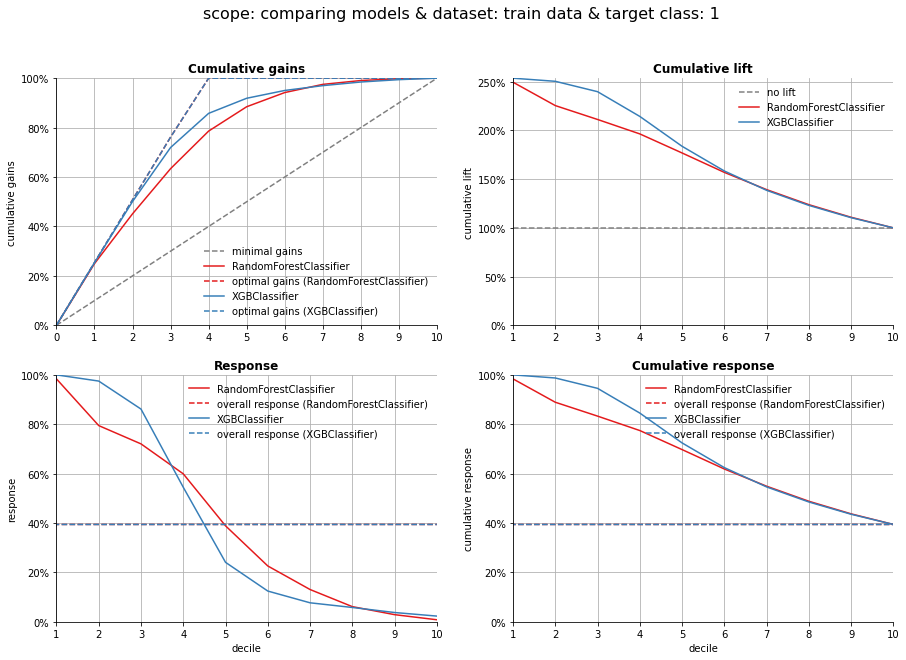

compare models
The label with smallest class is [1]


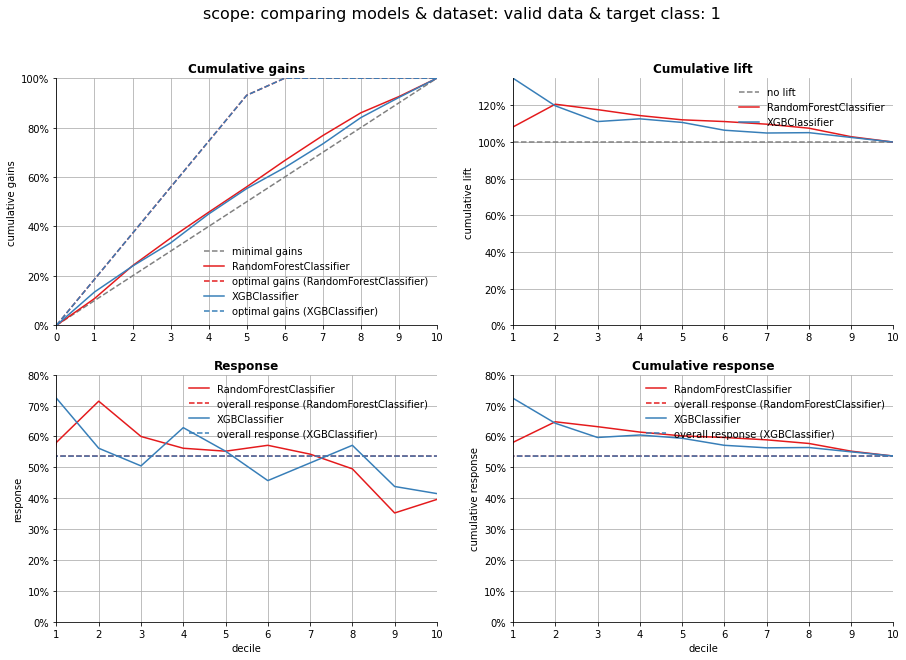

In [30]:
tsc.compare_models()

### Testing

Final model: RandomForestClassifier(bootstrap='True', max_depth=13, max_features='log2',
                       min_samples_leaf=5, n_estimators=87, n_jobs=-1,
                       random_state=0)
0    27656
1    17977
Name: y, dtype: int64
Fitting...
Test score for RandomForestClassifier = 0.8231378975885478
Took 2 seconds to get final predictions
Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is 1
Target class 1, dataset train data and model RandomForestClassifier.


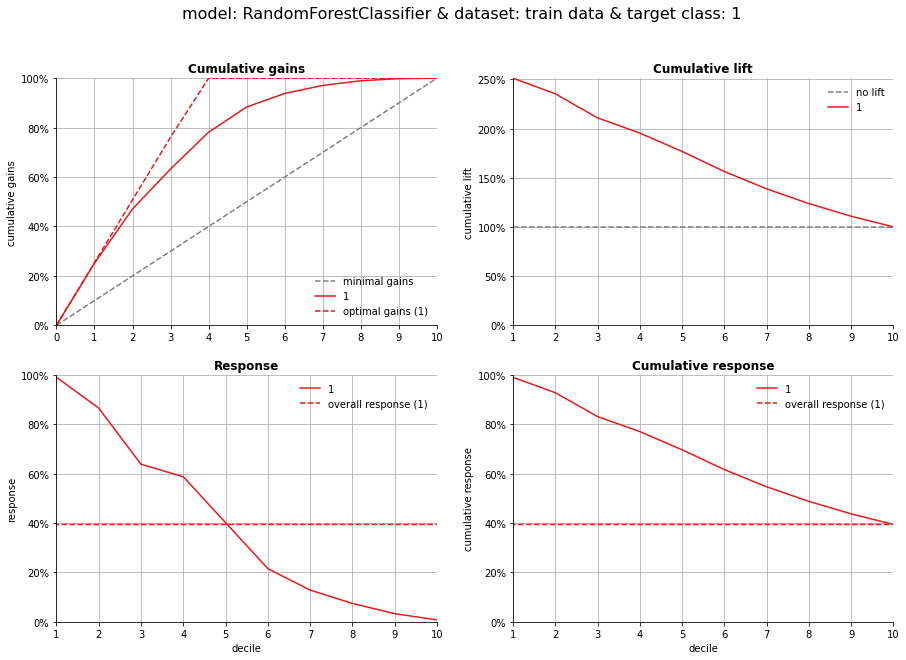

compare models
The label with smallest class is [1]


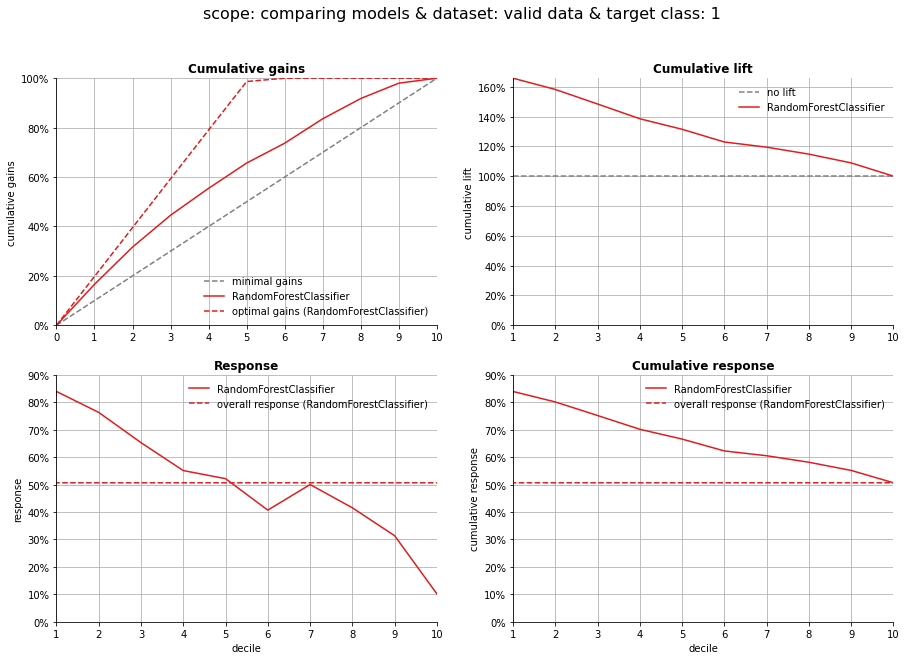

In [31]:
tsc.get_predictions()

### Model explainability

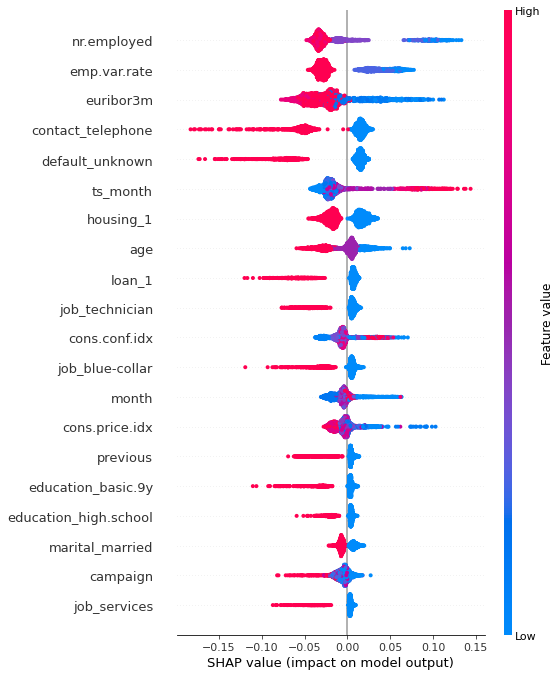

In [24]:
X_sampled = bank_data[bank_data['ts_month'] <= 20].sample(2500, random_state=0).drop(columns='y')
tree_explainer = shap.TreeExplainer(tsc.fitted_final_estimator)
shap_values = tree_explainer(X_sampled)
shap.summary_plot(shap_values[:, :, 1], X_sampled)